In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import re

In [2]:
data_dir = '../data'
df = pd.read_csv(os.path.join(data_dir,'temp_cond_price.csv'))
df

,datetime,Tsea,Xf,hour,Price
0,2020-10-12 00:00:00,33.700000,60.613333,0,0.03147
1,2020-10-12 01:00:00,33.700000,60.633333,1,0.02900
2,2020-10-12 02:00:00,33.700000,60.590000,2,0.02960
3,2020-10-12 03:00:00,33.673333,60.605000,3,0.02891
4,2020-10-12 04:00:00,33.600000,60.558333,4,0.02872
...,...,...,...,...,...
24092,2023-07-12 17:00:00,29.510256,56.523077,17,0.08872
24093,2023-07-12 18:00:00,29.510256,56.523077,18,0.09391
24094,2023-07-12 19:00:00,29.510256,56.523077,19,0.10919
24095,2023-07-12 20:00:00,29.510256,56.523077,20,0.11796


# Forecast

In [3]:
from neuralforecast.models import LSTM, NHITS, RNN
from neuralforecast.core import NeuralForecast

from utilsforecast.plotting import plot_series

from ray import tune

from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss, MAE
from neuralforecast.losses.numpy import mae, mape

from ray.tune.search.hyperopt import HyperOptSearch


## Input Data

In [13]:
cols = ['Tsea', 'Xf', 'Price']
var_name_dic = {'Tsea': 'Seawater Temperature (C)',
                'Xf': 'Seawater Conductivity (mS/cm)',
                'Price': 'Spot electricity price - Spain (EUR/kWh)'}

Y_df = pd.DataFrame()
for col in cols:
    df_ = df[['datetime', col]].rename(columns={'datetime':'ds', col:'y'})
    df_.insert(0, 'unique_id', col)
    Y_df = pd.concat([Y_df, df_], axis=0).reset_index(drop=True)

# cut last partial day
Y_df = Y_df[Y_df['ds'] < pd.to_datetime(Y_df.ds.dt.date.max())]

# add Calendar variables
Y_df['hour'] = Y_df['ds'].dt.hour
Y_df['doy'] = Y_df['ds'].dt.day_of_year
Y_df['dow'] = Y_df['ds'].dt.day_of_week

Y_df

,unique_id,ds,y,hour,doy,dow
0,Tsea,2020-10-12 00:00:00,33.700000,0,286,0
1,Tsea,2020-10-12 01:00:00,33.700000,1,286,0
2,Tsea,2020-10-12 02:00:00,33.700000,2,286,0
3,Tsea,2020-10-12 03:00:00,33.673333,3,286,0
4,Tsea,2020-10-12 04:00:00,33.600000,4,286,0
...,...,...,...,...,...,...
72264,Price,2023-07-11 19:00:00,0.109930,19,192,1
72265,Price,2023-07-11 20:00:00,0.126870,20,192,1
72266,Price,2023-07-11 21:00:00,0.128210,21,192,1
72267,Price,2023-07-11 22:00:00,0.125950,22,192,1


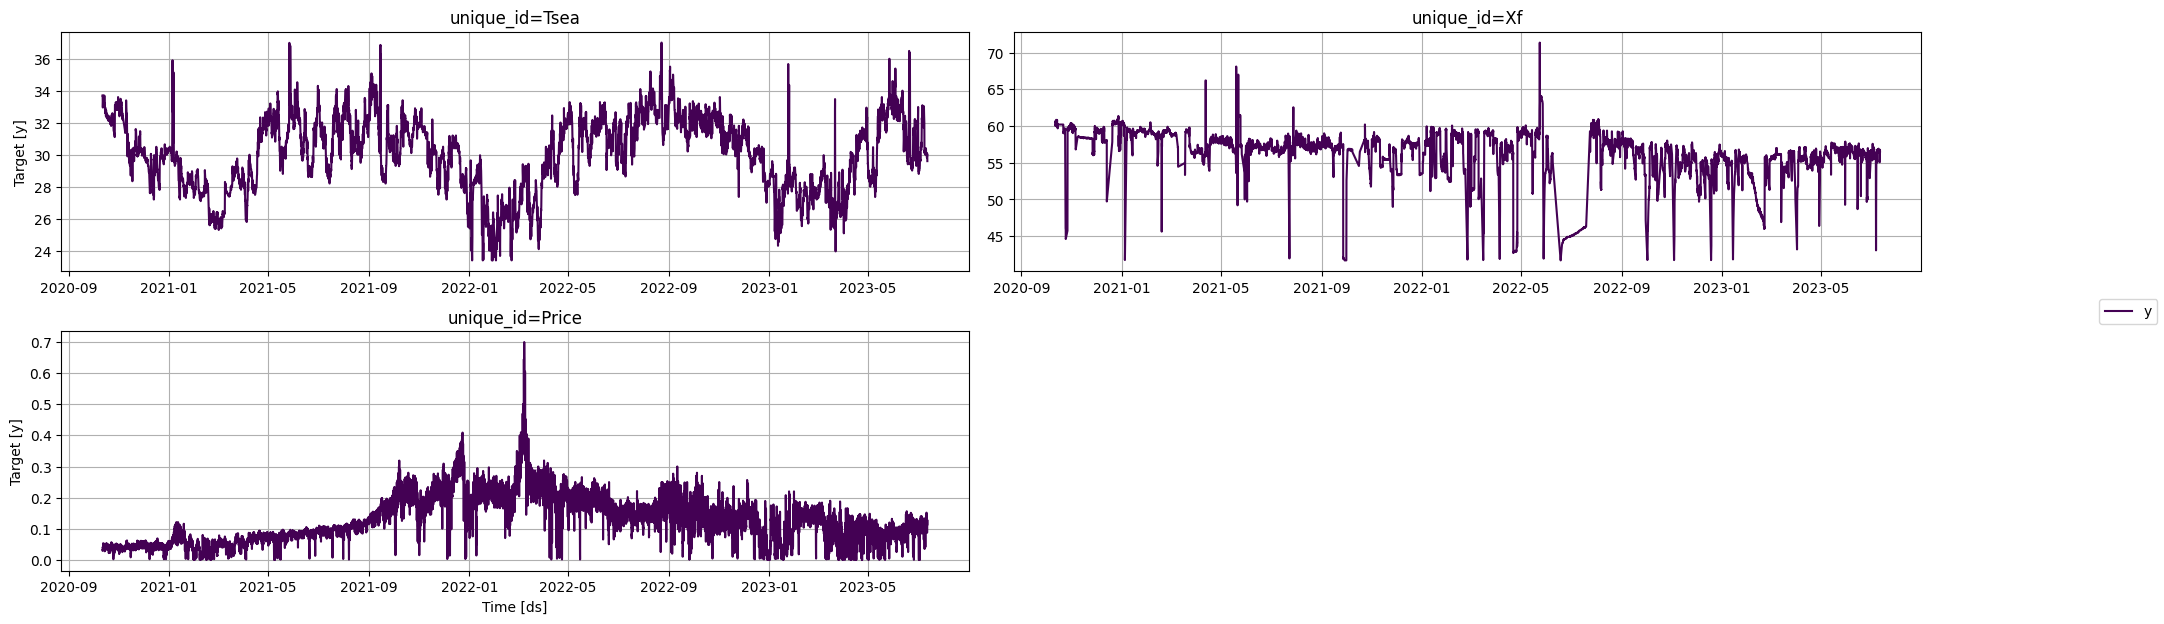

In [14]:
plot_series(Y_df)


In [15]:
Y_train = Y_df[Y_df['ds'] < '2023']
Y_val = Y_df[Y_df['ds'] >= '2023']

Y_train

,unique_id,ds,y,hour,doy,dow
0,Tsea,2020-10-12 00:00:00,33.700000,0,286,0
1,Tsea,2020-10-12 01:00:00,33.700000,1,286,0
2,Tsea,2020-10-12 02:00:00,33.700000,2,286,0
3,Tsea,2020-10-12 03:00:00,33.673333,3,286,0
4,Tsea,2020-10-12 04:00:00,33.600000,4,286,0
...,...,...,...,...,...,...
67656,Price,2022-12-31 19:00:00,0.018110,19,365,5
67657,Price,2022-12-31 20:00:00,0.007600,20,365,5
67658,Price,2022-12-31 21:00:00,0.003690,21,365,5
67659,Price,2022-12-31 22:00:00,0.001880,22,365,5


## Multiple Models

In [ ]:
horizon = 24
futr_exog_list = ['hour', 'doy', 'dow']

##################
# last_ix = np.mod(len(Y_train), horizon)
# Y_train_tr = Y_train.iloc[:-last_ix]

# Try different hyperparmeters to improve accuracy.
models = [
    LSTM(h=horizon,                    # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               futr_exog_list = futr_exog_list, # future exogenous columns
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64),       # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=5 * horizon,      # Length of input sequence
                max_steps=500,               # Number of steps to train
                futr_exog_list = futr_exog_list, # future exogenous columns
                n_freq_downsample=[2, 1, 1], # Downsampling factors for each stack output
                scaler_type = 'robust')
          ]

Global seed set to 1


Global seed set to 1


In [ ]:
nf = NeuralForecast(models=models, freq='H')
nf.fit(df=Y_train)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

### Save (& Load) Model

In [ ]:
nf.save(path='./checkpoints/test_run/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

In [24]:
nf = NeuralForecast.load(path='./checkpoints/test_run/')
# Y_hat_df = nf.predict().reset_index()
# Y_hat_df.head()

Global seed set to 1


Global seed set to 1


### Predict Insample

In [18]:
Y_hat_insample  = nf.predict_insample(step_size=1)
Y_hat_insample

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,cutoff,LSTM,NHITS,y
0,Price,2020-10-11 21:00:00,2020-10-11 20:00:00,-3.316792,-0.767517,NaN
1,Price,2020-10-11 22:00:00,2020-10-11 20:00:00,-16.491402,-0.558993,NaN
2,Price,2020-10-11 23:00:00,2020-10-11 20:00:00,-9.908624,1.140497,NaN
3,Price,2020-10-12 00:00:00,2020-10-11 20:00:00,-17.517946,-0.124009,0.031470
4,Price,2020-10-12 01:00:00,2020-10-11 20:00:00,-19.805878,0.029949,0.029000
...,...,...,...,...,...,...
1400179,Xf,2022-12-31 19:00:00,2022-12-30 23:00:00,-18.919214,55.826290,55.818195
1400180,Xf,2022-12-31 20:00:00,2022-12-30 23:00:00,-14.978560,55.818981,55.813889
1400181,Xf,2022-12-31 21:00:00,2022-12-30 23:00:00,-17.765114,55.823093,55.809582
1400182,Xf,2022-12-31 22:00:00,2022-12-30 23:00:00,-16.342636,55.826740,55.805279


In [19]:
Y_hat_insample_ds = pd.DataFrame()
unique_ids = Y_train['unique_id'].unique()
for unique_id in unique_ids:
    df_ = Y_train[Y_train['unique_id'] == unique_id]
    ix = np.arange(5*horizon,len(df_), horizon)
    keep_cutoff = df_.iloc[ix].ds
    
    mask = (Y_hat_insample['unique_id'] == unique_id) & (Y_hat_insample['cutoff'].isin(keep_cutoff))
    _ = Y_hat_insample.loc[mask]

    Y_hat_insample_ds = pd.concat([Y_hat_insample_ds, _], axis=0).reset_index(drop=True)
Y_hat_insample_ds

,unique_id,ds,cutoff,LSTM,NHITS,y
0,Tsea,2020-10-17 01:00:00,2020-10-17 00:00:00,2.665197,32.394482,32.500000
1,Tsea,2020-10-17 02:00:00,2020-10-17 00:00:00,-10.467088,32.394600,32.430000
2,Tsea,2020-10-17 03:00:00,2020-10-17 00:00:00,-3.908592,32.387444,32.400002
3,Tsea,2020-10-17 04:00:00,2020-10-17 00:00:00,-11.745711,32.396454,32.384998
4,Tsea,2020-10-17 05:00:00,2020-10-17 00:00:00,-13.772431,32.390354,32.301666
...,...,...,...,...,...,...
58036,Price,2022-12-31 17:00:00,2022-12-30 21:00:00,-22.943808,-0.006500,0.004110
58037,Price,2022-12-31 18:00:00,2022-12-30 21:00:00,-18.739758,-0.001247,0.020000
58038,Price,2022-12-31 19:00:00,2022-12-30 21:00:00,-21.858921,0.000230,0.018110
58039,Price,2022-12-31 20:00:00,2022-12-30 21:00:00,-20.606052,-0.000453,0.007600


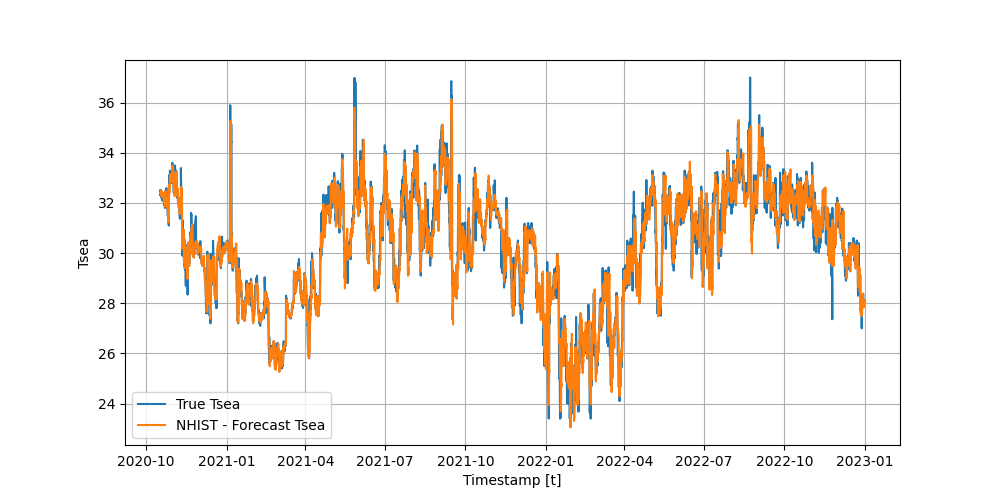

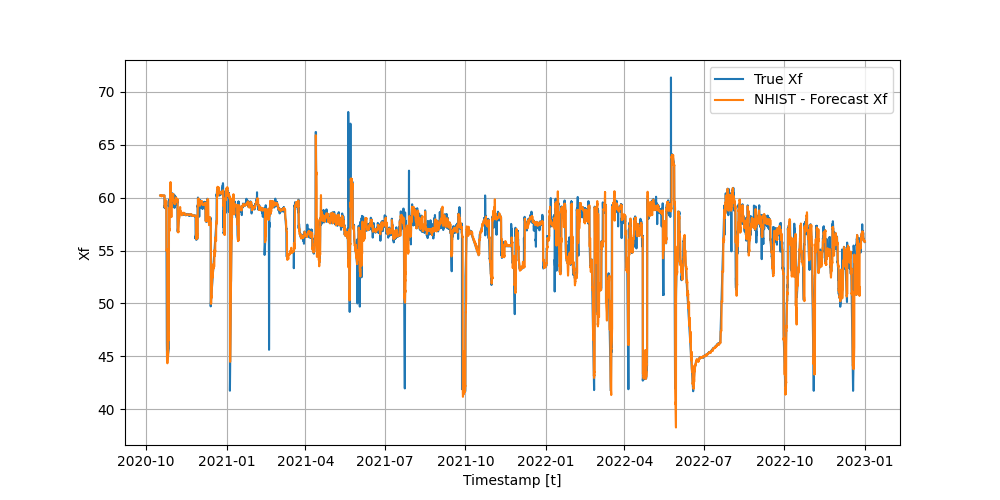

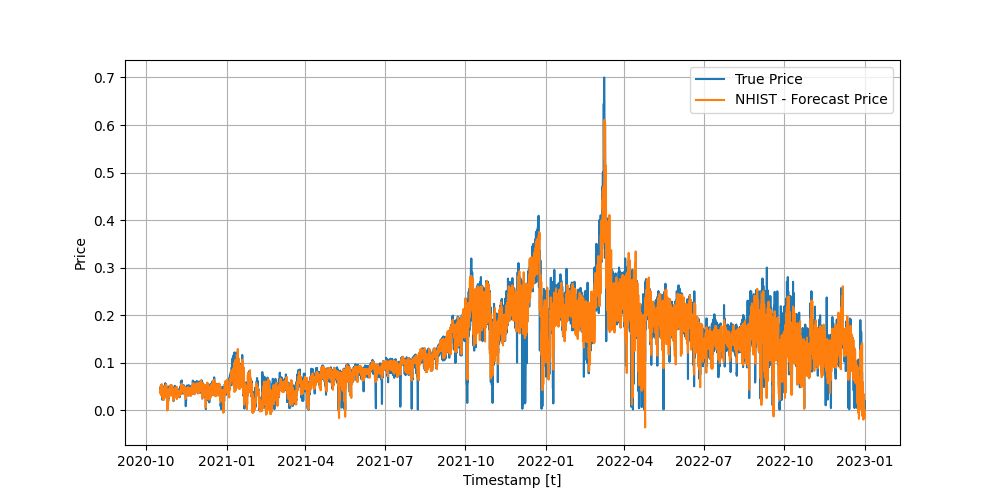

In [21]:
%matplotlib widget
for unique_id in unique_ids:
    df_ = Y_hat_insample_ds[Y_hat_insample_ds['unique_id'] == unique_id]

    plt.figure(figsize=(10, 5))
    plt.plot(df_['ds'], df_['y'], label=f'True {unique_id}')
    plt.plot(df_['ds'], df_['NHITS'], label=f'NHIST - Forecast {unique_id}')
    # plt.plot(df_['ds'], df_['LSTM'], label=f'LSTM - Forecast {unique_id}')
    # plt.axvline(df_['ds'].iloc[-12], color='black', linestyle='--', label='Train-Test Split')
    plt.xlabel('Timestamp [t]')
    plt.ylabel(unique_id)
    plt.grid()
    plt.legend()
    plt.show()


### Forecast for Future Horizon
Using validation data set not used for training

In [ ]:
Y_hat= nf.predict(df=Y_train, futr_df=Y_val)
Y_hat = Y_hat.reset_index()
Y_hat

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,LSTM,NHITS
0,Price,2023-01-01 00:00:00,-0.004935,-0.005334
1,Price,2023-01-01 01:00:00,-0.005868,-0.002982
2,Price,2023-01-01 02:00:00,-0.008964,-0.008492
3,Price,2023-01-01 03:00:00,-0.008675,-0.006309
4,Price,2023-01-01 04:00:00,-0.011770,-0.002645
...,...,...,...,...
67,Xf,2023-01-01 19:00:00,55.615597,56.113251
68,Xf,2023-01-01 20:00:00,55.683079,56.094257
69,Xf,2023-01-01 21:00:00,55.714024,56.089512
70,Xf,2023-01-01 22:00:00,55.591991,56.047070


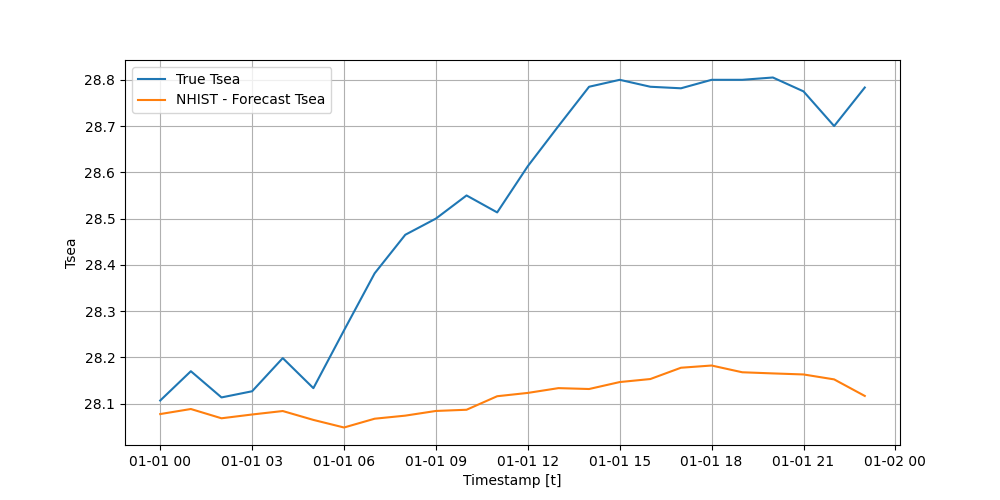

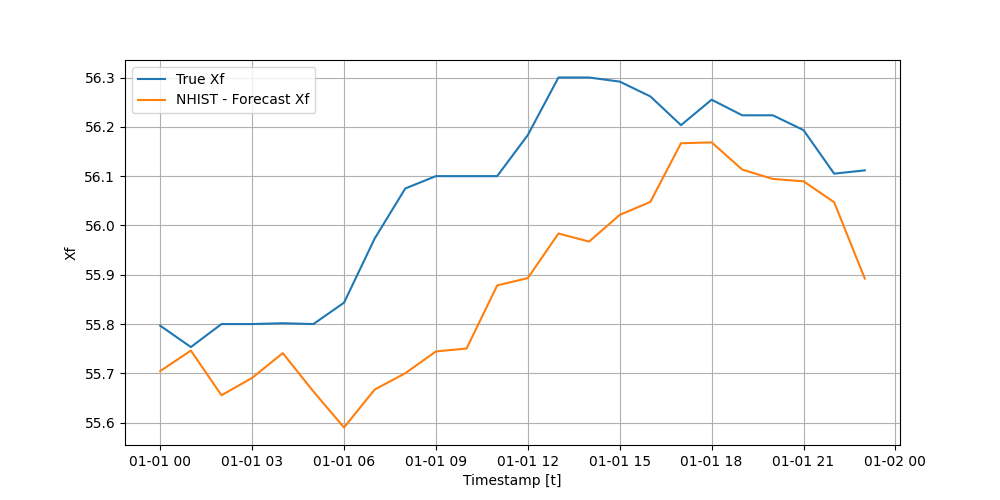

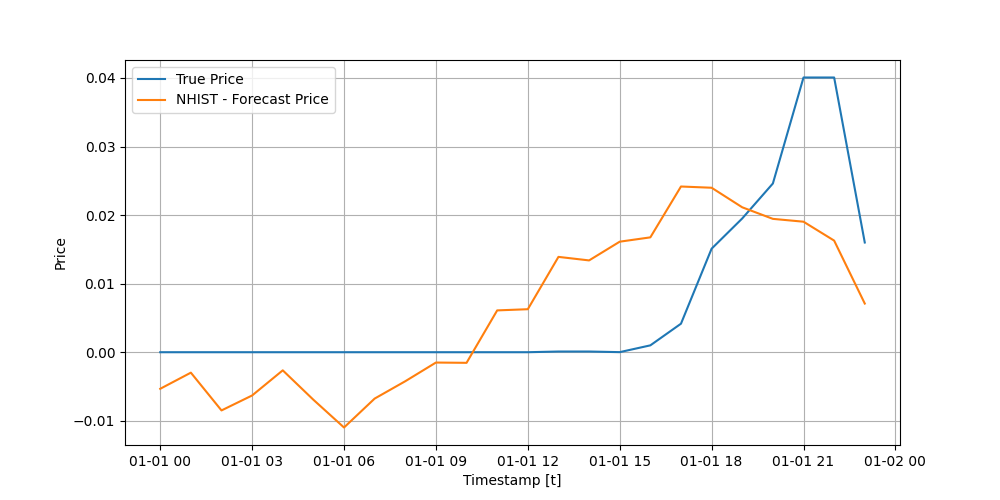

In [ ]:
for unique_id in unique_ids:
    df_hat = Y_hat[Y_hat['unique_id'] == unique_id]
    df_ = Y_val[(Y_val['unique_id'] == unique_id) & (Y_val['ds'] <= df_hat['ds'].max())]

    plt.figure(figsize=(10, 5))
    plt.plot(df_['ds'], df_['y'], label=f'True {unique_id}')
    plt.plot(df_hat['ds'], df_hat['NHITS'], label=f'NHIST - Forecast {unique_id}')
    
    plt.xlabel('Timestamp [t]')
    plt.ylabel(unique_id)
    plt.grid()
    plt.legend()
    plt.show()


## Train on the entire data set

In [16]:
horizon = 24
futr_exog_list = ['hour', 'doy', 'dow']

models = [
          NHITS(h=horizon,                   # Forecast horizon
                input_size=5 * horizon,      # Length of input sequence
                max_steps=500,               # Number of steps to train
                futr_exog_list = futr_exog_list, # future exogenous columns
                n_freq_downsample=[2, 1, 1], # Downsampling factors for each stack output
                scaler_type = 'robust')
          ]

Global seed set to 1


In [18]:
nf = NeuralForecast(models=models, freq='H')
nf.fit(df=Y_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Save (& Load) Model

In [19]:
nf.save(path='./checkpoints/test_run_all_ds/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

In [28]:
nf = NeuralForecast.load(path='./checkpoints/test_run_all_ds/')
# Y_hat_df = nf.predict().reset_index()
# Y_hat_df.head()

Global seed set to 1


### Predict Insample

In [20]:
Y_hat_insample  = nf.predict_insample(step_size=1)
Y_hat_insample

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,cutoff,NHITS,y
0,Price,2020-10-11 21:00:00,2020-10-11 20:00:00,-2.007077,NaN
1,Price,2020-10-11 22:00:00,2020-10-11 20:00:00,-3.319455,NaN
2,Price,2020-10-11 23:00:00,2020-10-11 20:00:00,-3.216484,NaN
3,Price,2020-10-12 00:00:00,2020-10-11 20:00:00,-4.357256,0.031470
4,Price,2020-10-12 01:00:00,2020-10-11 20:00:00,-4.981731,0.029000
...,...,...,...,...,...
1731955,Xf,2023-07-11 19:00:00,2023-07-10 23:00:00,56.710548,56.685001
1731956,Xf,2023-07-11 20:00:00,2023-07-10 23:00:00,56.689186,56.764999
1731957,Xf,2023-07-11 21:00:00,2023-07-10 23:00:00,56.687550,56.743332
1731958,Xf,2023-07-11 22:00:00,2023-07-10 23:00:00,56.656090,56.645000


In [30]:
# save insample predictions for future use
Y_hat_insample.to_csv('./checkpoints/test_run_all_ds/Y_hat_insample.csv', index=False)

In [25]:
Y_hat_insample_ds = pd.DataFrame()
unique_ids = Y_df['unique_id'].unique()
for unique_id in unique_ids:
    df_ = Y_df[Y_df['unique_id'] == unique_id]
    ix = np.arange(5*horizon,len(df_), horizon)
    keep_cutoff = df_.iloc[ix].ds
    
    mask = (Y_hat_insample['unique_id'] == unique_id) & (Y_hat_insample['cutoff'].isin(keep_cutoff))
    _ = Y_hat_insample.loc[mask]

    Y_hat_insample_ds = pd.concat([Y_hat_insample_ds, _], axis=0).reset_index(drop=True)
Y_hat_insample_ds

,unique_id,ds,cutoff,NHITS,y
0,Tsea,2020-10-17 01:00:00,2020-10-17 00:00:00,32.397476,32.500000
1,Tsea,2020-10-17 02:00:00,2020-10-17 00:00:00,32.379456,32.430000
2,Tsea,2020-10-17 03:00:00,2020-10-17 00:00:00,32.378609,32.400002
3,Tsea,2020-10-17 04:00:00,2020-10-17 00:00:00,32.354366,32.384998
4,Tsea,2020-10-17 05:00:00,2020-10-17 00:00:00,32.350048,32.301666
...,...,...,...,...,...
71860,Price,2023-07-11 17:00:00,2023-07-10 21:00:00,0.101298,0.090710
71861,Price,2023-07-11 18:00:00,2023-07-10 21:00:00,0.117410,0.092610
71862,Price,2023-07-11 19:00:00,2023-07-10 21:00:00,0.131122,0.109930
71863,Price,2023-07-11 20:00:00,2023-07-10 21:00:00,0.144991,0.126870


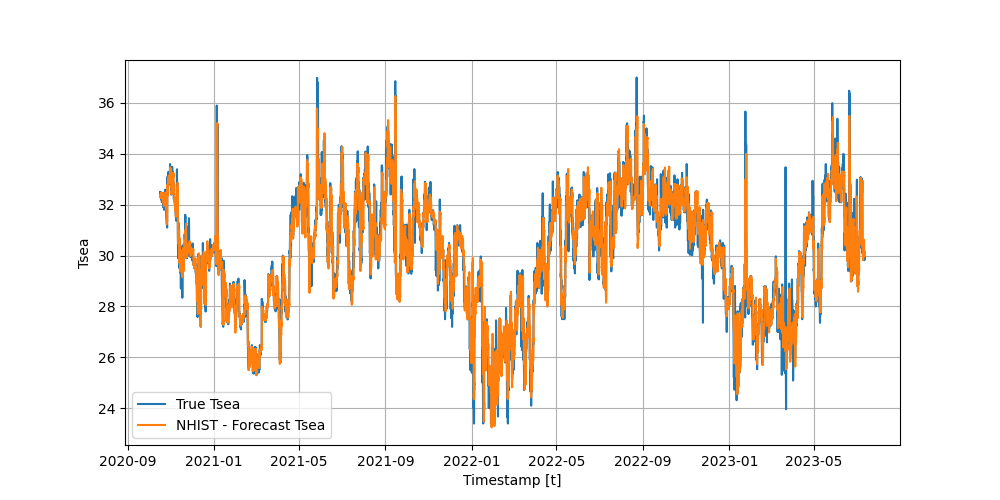

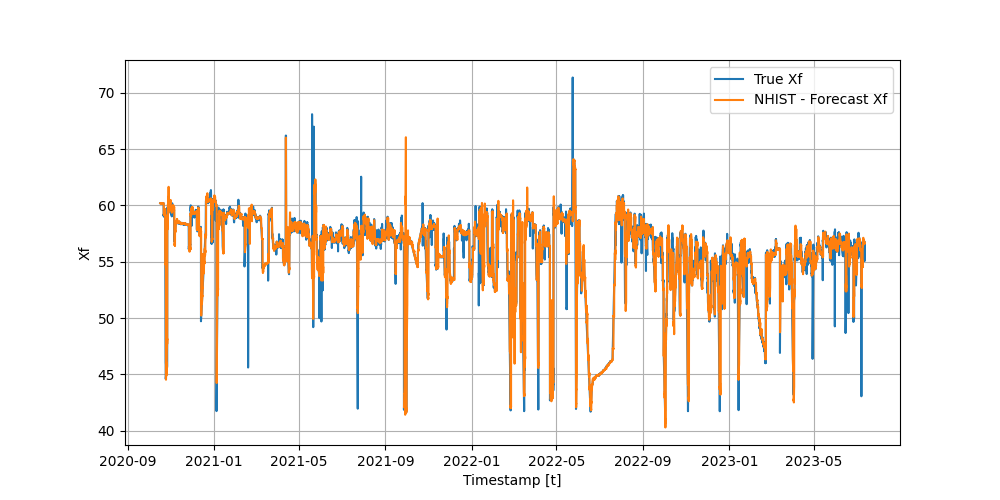

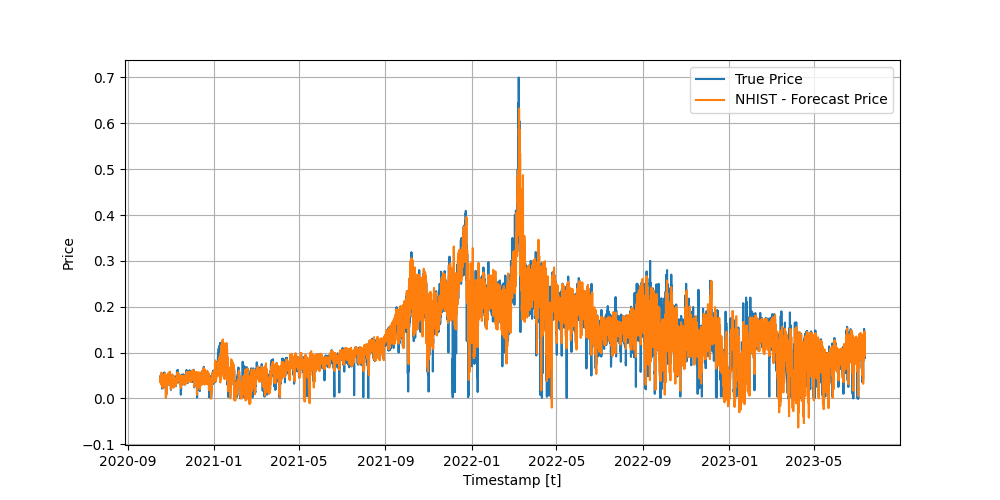

In [26]:
%matplotlib widget
for unique_id in unique_ids:
    df_ = Y_hat_insample_ds[Y_hat_insample_ds['unique_id'] == unique_id]

    plt.figure(figsize=(10, 5))
    plt.plot(df_['ds'], df_['y'], label=f'True {unique_id}')
    plt.plot(df_['ds'], df_['NHITS'], label=f'NHIST - Forecast {unique_id}')
    plt.xlabel('Timestamp [t]')
    plt.ylabel(unique_id)
    plt.grid()
    plt.legend()
    plt.show()


## Cross-validation
https://nixtlaverse.nixtla.io/neuralforecast/examples/cross_validation_tutorial.html <br>

The cross_validation method allows you to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with fit and predict methods.

In [ ]:
# NOTE: this is extremely slow and stops the kernel!
Y_hat = pd.DataFrame()
for unique_id in unique_ids:
    df_ = Y_val[Y_val['unique_id'] == unique_id]

    ixs = np.arange(5*horizon,len(df_)-horizon, horizon)
    for ix in ixs:
        y_hat = nf.predict(df=df_.iloc[:ix], futr_df=df_.iloc[ix:], verbose=False).reset_index()
        y_hat = y_hat.merge(df_[['ds', 'y']], on='ds', how='left')
        Y_hat = pd.concat([Y_hat, y_hat], axis=0).reset_index(drop=True)
        
Y_hat

In [ ]:
models = [NHITS(h=horizon,                   # Forecast horizon
                input_size=5 * horizon,      # Length of input sequence
                max_steps=200,               # Number of steps to train
                futr_exog_list = futr_exog_list, # future exogenous columns
                n_freq_downsample=[2, 1, 1], # Downsampling factors for each stack output
                scaler_type = 'robust')
          ]
nf = NeuralForecast(models=models, freq='H')

Global seed set to 1


In [ ]:
# This trains the model using the data before the first (chronological) window
cv_df = nf.cross_validation(Y_df, n_windows=50, step_size=horizon)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

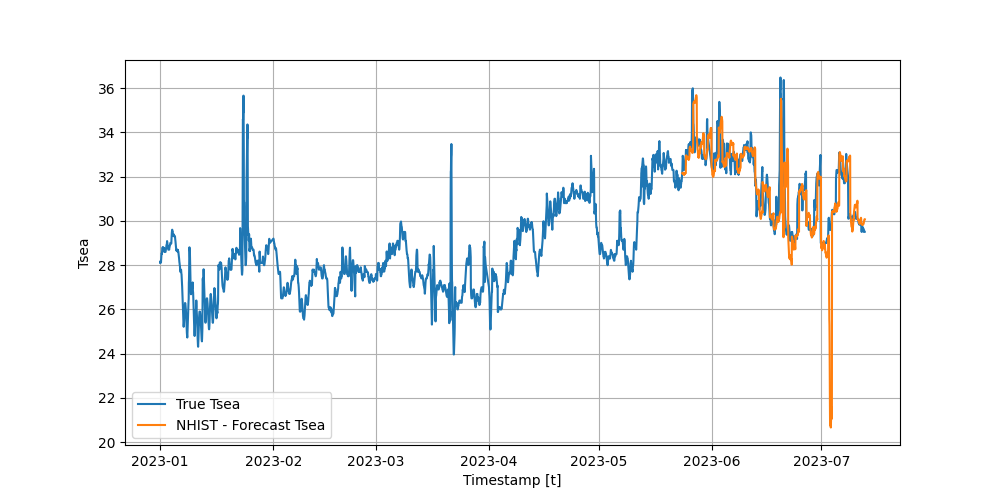

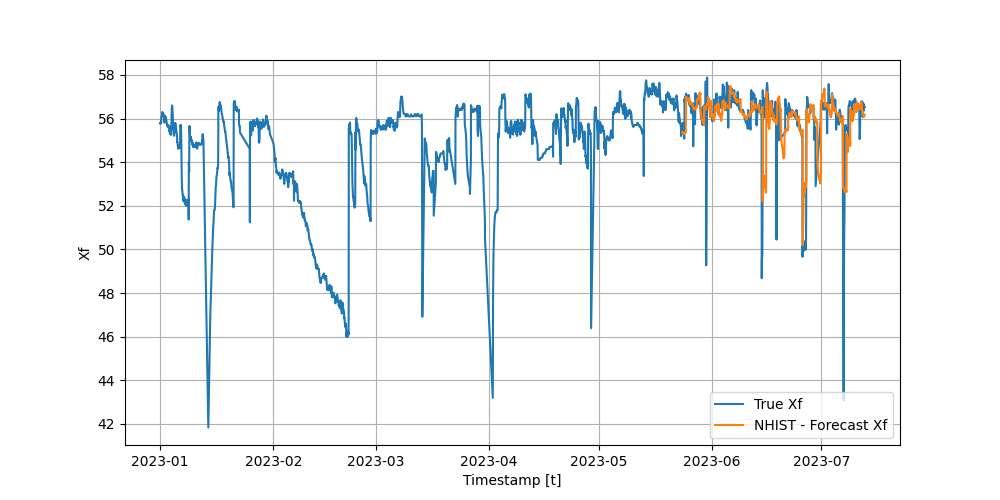

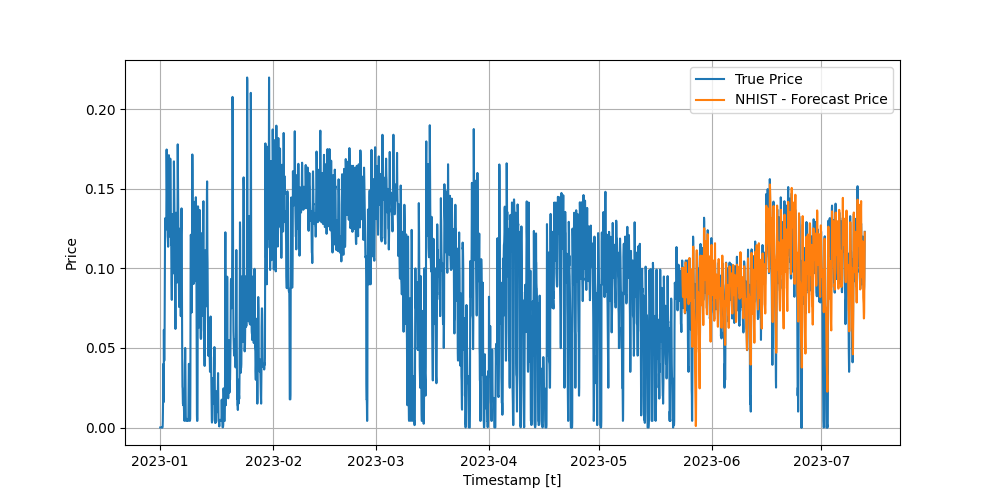

In [ ]:
for unique_id in unique_ids:
    cv_df_ = cv_df[cv_df['unique_id'] == unique_id]
    Y_val_ = Y_val[(Y_val['unique_id'] == unique_id)]

    plt.figure(figsize=(10, 5))
    plt.plot(Y_val_['ds'], Y_val_['y'], label=f'True {unique_id}')
    plt.plot(cv_df_['ds'], cv_df_['NHITS'], label=f'NHIST - Forecast {unique_id}')
    
    plt.xlabel('Timestamp [t]')
    plt.ylabel(unique_id)
    plt.grid()
    plt.legend()
    plt.show()


## Hyperparamter Optimization
https://nixtlaverse.nixtla.io/neuralforecast/examples/getting_started_complete.html

In [ ]:
# Custom search space for the AutoNHITS and AutoLSTM models

config_nhits = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
    # "trial_dirname_creator": shortern_trial_dirname
}

# config_lstm = {
#     "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
#     "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
#     "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
#     "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
#     "scaler_type": tune.choice(['robust']),                   # Scaler type
#     "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
#     "batch_size": tune.choice([1, 4]),                        # Number of series in batch
#     "random_seed": tune.randint(1, 20),                       # Random seed
# }


In [ ]:
horizon = 24 # hours
# input_size = 2*horizon
# futr_exog_list = ['hour', 'doy', 'dow']

models=[
        AutoNHITS(h=12,
                  loss=MAE(),
                  config=config_nhits,
                  search_alg=HyperOptSearch(),
                  # backend="optuna",
                  # backend='ray',
                  num_samples=10) # As a general rule, we recommend setting num_samples higher than 20.

        # AutoLSTM(h=horizon,  # search_alg=?
        #          config=config_lstm, 
        #          loss=MQLoss(), 
        #          num_samples=5),  # As a general rule, we recommend setting num_samples higher than 20.
    ]

nf_hp = NeuralForecast(models=models, freq='H')


In [ ]:
# from ray import tune
# def shortern_trial_dirname(trial):
#     # return "{}_{}_123".format(trial.trainable_name, trial.trial_id)
#     trialname = algorithm + "_" + environment + "_" + model 
#     info_to_file(trialname + "_" + time.strftime("%Y-%m-%d_%H-%M-%S") + trial.trial_id)
#     return trialname

# tune.TuneConfig(trial_dirname_creator=shortern_trial_dirname)

TuneConfig(mode=None, metric=None, search_alg=None, scheduler=None, num_samples=1, max_concurrent_trials=None, time_budget_s=None, reuse_actors=False, trial_name_creator=None, trial_dirname_creator=<function shortern_trial_dirname at 0x000001E81EC3ACB0>, chdir_to_trial_dir='DEPRECATED')

In [ ]:
# use val_size to control the length of the validation set
# Y_df_0 = Y_train[['unique_id', 'ds', 'y']]
nf_hp.fit(df=Y_df, val_size=50*horizon)

2024-04-05 14:06:55,887	WARNING trial.py:648 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\SESA69~1\AppData\Local\Temp\ray\session_2024-04-05_14-00-53_721238_32456\artifacts\2024-04-05_14-06-55\_train_tune_2024-04-05_14-06-55\driver_artifacts\_train_tune_30d8038c_1_batch_size=10,h=12,input_size=144,learning_rate=0.0002,loss=ref_ph_de895953,max_steps=1000,mlp_units=64_64__2024-04-05_14-06-55


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\SESA69~1\\AppData\\Local\\Temp\\ray\\session_2024-04-05_14-00-53_721238_32456\\artifacts\\2024-04-05_14-06-55\\_train_tune_2024-04-05_14-06-55\\driver_artifacts\\_train_tune_30d8038c_1_batch_size=10,h=12,input_size=144,learning_rate=0.0002,loss=ref_ph_de895953,max_steps=1000,mlp_units=64_64__2024-04-05_14-06-55'

## Probabilistic Forecast
https://nixtlaverse.nixtla.io/neuralforecast/examples/uncertaintyintervals.html

In [16]:
horizon = 24
# levels = [68, 80, 90, 95]
levels = [80, 90]
futr_exog_list = ['hour', 'doy', 'dow']

models = [
      #     LSTM(h=horizon,                    # Forecast horizon
      #          max_steps=500,                # Number of steps to train
      #          loss=MQLoss(level=levels),
      #          scaler_type='standard',       # Type of scaler to normalize data
      #          futr_exog_list = futr_exog_list, # future exogenous columns
      #          encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
      #          decoder_hidden_size=64),       # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=5 * horizon,      # Length of input sequence
                max_steps=500,               # Number of steps to train
                loss=MQLoss(level=levels),
                futr_exog_list = futr_exog_list, # future exogenous columns
                n_freq_downsample=[2, 1, 1], # Downsampling factors for each stack output
                scaler_type = 'robust')
          ]

# models = [LSTM(input_size=5*horizon, h=horizon,
#                loss=MQLoss(level=levels), max_steps=500),
#           NHITS(input_size=5*horizon, h=horizon,
#                 n_freq_downsample=[24, 12, 1],
#                 loss=MQLoss(level=levels), max_steps=500),]
nf_prb = NeuralForecast(models=models, freq='H')


Global seed set to 1


In [ ]:
# This trains the model using the data before the first (chronological) window
cv_df = nf_prb.cross_validation(Y_df, n_windows=50, step_size=horizon)
# nf_prb.fit(df=Y_train)

nf_prb.save(path='./checkpoints/test_run_probabilistic/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

cv_df.to_csv('./checkpoints/test_run_probabilistic/cv_df.csv', index=False)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

### Load Model

In [17]:
nf = NeuralForecast.load(path='./checkpoints/test_run_probabilistic/')
# Y_hat_df = nf.predict().reset_index()
cv_df = pd.read_csv('./checkpoints/test_run_probabilistic/cv_df.csv')
cv_df['ds'] = pd.to_datetime(cv_df['ds'])
cv_df

Global seed set to 1


,unique_id,ds,cutoff,NHITS-median,NHITS-lo-90,NHITS-lo-80,NHITS-hi-80,NHITS-hi-90,y,hour,doy,dow
0,Price,2023-05-23 00:00:00,2023-05-22 23:00:00,0.080350,0.060459,0.068556,0.093360,0.100827,0.096150,0,143,1
1,Price,2023-05-23 01:00:00,2023-05-22 23:00:00,0.077229,0.051476,0.057547,0.089723,0.099652,0.093600,1,143,1
2,Price,2023-05-23 02:00:00,2023-05-22 23:00:00,0.072357,0.040763,0.049313,0.090882,0.095349,0.082000,2,143,1
3,Price,2023-05-23 03:00:00,2023-05-22 23:00:00,0.065099,0.035640,0.043830,0.086195,0.089356,0.080000,3,143,1
4,Price,2023-05-23 04:00:00,2023-05-22 23:00:00,0.068764,0.031538,0.040983,0.083866,0.084421,0.079570,4,143,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,Xf,2023-07-11 19:00:00,2023-07-10 23:00:00,60.002330,56.688114,57.312160,62.625736,63.781998,56.685000,19,192,1
3596,Xf,2023-07-11 20:00:00,2023-07-10 23:00:00,60.096954,56.887295,57.536194,62.868248,63.893350,56.765000,20,192,1
3597,Xf,2023-07-11 21:00:00,2023-07-10 23:00:00,60.367850,56.751050,57.506016,62.821434,64.138890,56.743333,21,192,1
3598,Xf,2023-07-11 22:00:00,2023-07-10 23:00:00,60.305347,56.506393,57.286460,63.028748,64.254330,56.645000,22,192,1


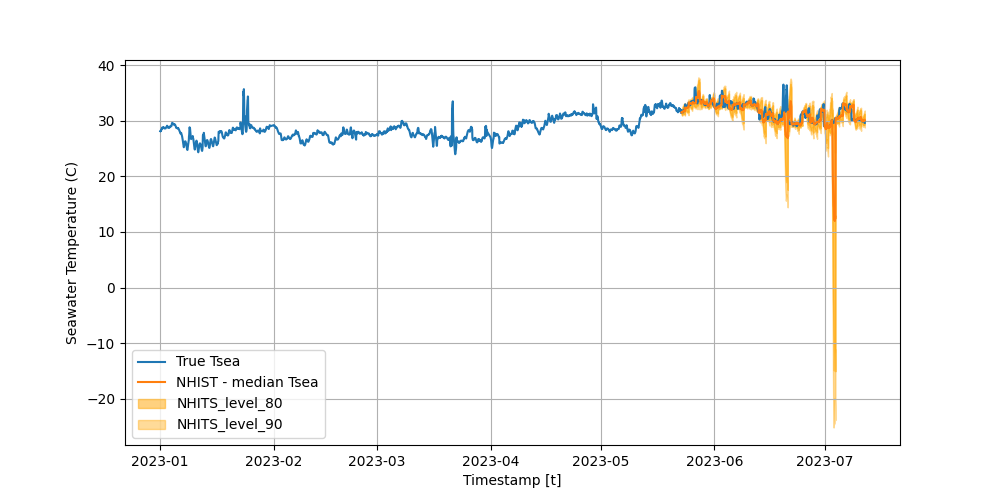

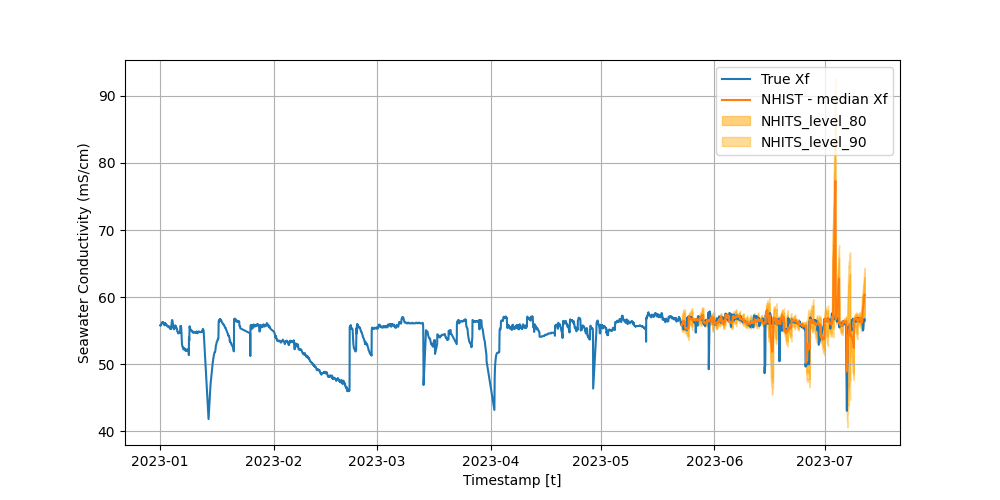

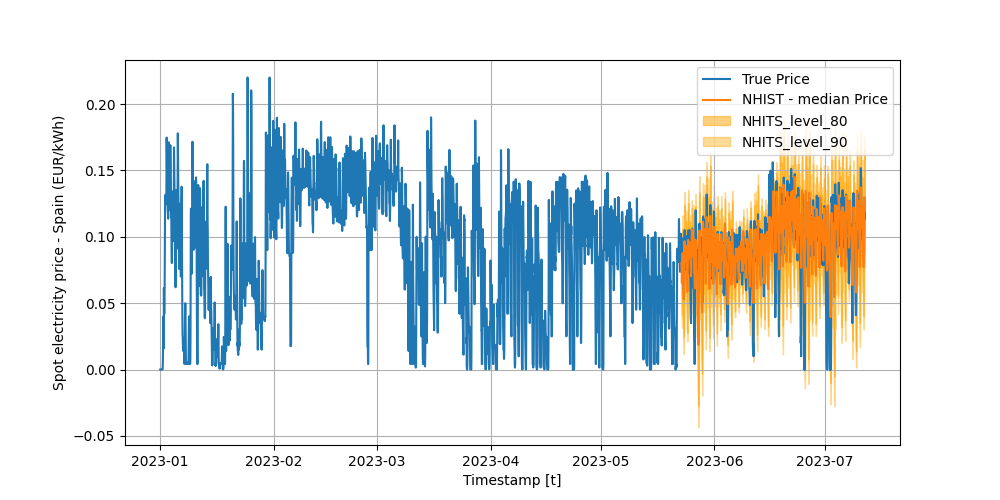

In [24]:
model = 'NHITS'
unique_ids = Y_train['unique_id'].unique()

for unique_id in unique_ids:
    fig, ax = plt.subplots(figsize=(10,5))

    cv_df_ = cv_df[cv_df['unique_id'] == unique_id]
    Y_val_ = Y_val[(Y_val['unique_id'] == unique_id)]

    plt.plot(Y_val_['ds'], Y_val_['y'], label=f'True {unique_id}')
    plt.plot(cv_df_['ds'], cv_df_['NHITS-median'], label=f'NHIST - median {unique_id}')

    for l, alpha in zip(sorted(levels), [0.5, .4, .35, .2]):
                    ax.fill_between(
                        cv_df_['ds'], 
                        cv_df_[f'{model}-lo-{l}'], 
                        cv_df_[f'{model}-hi-{l}'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
    
    plt.xlabel('Timestamp [t]')
    plt.ylabel(var_name_dic[unique_id])
    plt.grid()
    plt.legend()
    plt.show()


In [23]:
for unique_id in unique_ids:
    df_ = cv_df[cv_df['unique_id'] == unique_id]
    mae_nhist = mae(df_['y'], df_['NHITS-median'])
    mape_nhist = mape(df_['y'], df_['NHITS-median'])

    print(f'MAE -- NHIST {unique_id}: {mae_nhist:.3f}')
    print(f'MAPE -- NHIST {unique_id}: {mape_nhist:.3f}')
    print('============================')


MAE -- NHIST Tsea: 0.949
MAPE -- NHIST Tsea: 0.030
MAE -- NHIST Xf: 0.872
MAPE -- NHIST Xf: 0.016
MAE -- NHIST Price: 0.012
MAPE -- NHIST Price: 6.386


## Transformer Models
https://nixtlaverse.nixtla.io/neuralforecast/examples/longhorizon_with_transformers.html

In [15]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, PatchTST

In [16]:
horizon = 24
futr_exog_list = ['hour', 'doy', 'dow']


models = [Informer(h=horizon,                 # Forecasting horizon
                input_size=5*horizon,           # Input size
                futr_exog_list = futr_exog_list,
                max_steps=1000,               # Number of training iterations
                val_check_steps=100,          # Compute validation loss every 100 steps
                early_stop_patience_steps=3, # Stop training if validation loss does not improve
                enable_checkpointing=True),
          Autoformer(h=horizon,
                input_size=5*horizon,
                futr_exog_list = futr_exog_list,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=3,
                enable_checkpointing=True),
          PatchTST(h=horizon,
                input_size=5*horizon,
            #     futr_exog_list = futr_exog_list, # PatchTST does not support exog vars
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=3,
                enable_checkpointing=True),
         ]


Global seed set to 1
Global seed set to 1
Global seed set to 1


### Train and Save Model

In [ ]:
nf = NeuralForecast(
    models=models,
    freq='H')

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=50*horizon,
                            #    test_size=test_size,
                               n_windows=50, step_size=horizon)

nf.save(path='./checkpoints/test_run_transformer/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

Y_hat_df.to_csv('./checkpoints/test_run_transformer/Y_hat_df.csv', index=False)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

### Load Model

In [17]:
nf = NeuralForecast.load(path='./checkpoints/test_run_transformer/')
# Y_hat_df = nf.predict().reset_index()
Y_hat_df = pd.read_csv('./checkpoints/test_run_transformer/Y_hat_df.csv')
Y_hat_df['ds'] = pd.to_datetime(Y_hat_df['ds'])
Y_hat_df

Global seed set to 1
Global seed set to 1
Global seed set to 1


,unique_id,ds,cutoff,Informer,Autoformer,PatchTST,y,hour,doy,dow
0,Price,2023-05-23 22:00:00,2023-05-23 21:00:00,-0.112568,0.063057,0.105133,0.104790,22,143,1
1,Price,2023-05-23 23:00:00,2023-05-23 21:00:00,-0.160551,0.052309,0.105865,0.098530,23,143,1
2,Price,2023-05-24 00:00:00,2023-05-23 21:00:00,-0.184245,0.048656,0.103754,0.094530,0,144,2
3,Price,2023-05-24 01:00:00,2023-05-23 21:00:00,-0.376126,0.047969,0.101862,0.090000,1,144,2
4,Price,2023-05-24 02:00:00,2023-05-23 21:00:00,-0.427611,0.049031,0.099329,0.078770,2,144,2
...,...,...,...,...,...,...,...,...,...,...
3595,Xf,2023-07-12 17:00:00,2023-07-11 21:00:00,24.373316,55.779114,56.553050,56.523077,17,193,2
3596,Xf,2023-07-12 18:00:00,2023-07-11 21:00:00,24.373953,55.771187,56.464962,56.523077,18,193,2
3597,Xf,2023-07-12 19:00:00,2023-07-11 21:00:00,24.374544,55.746190,56.451885,56.523077,19,193,2
3598,Xf,2023-07-12 20:00:00,2023-07-11 21:00:00,24.375065,55.709050,56.496910,56.523077,20,193,2


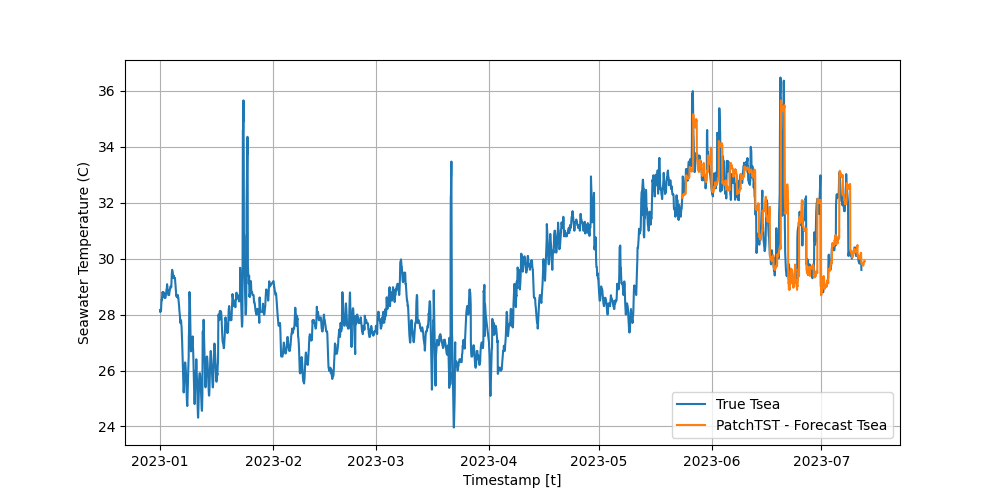

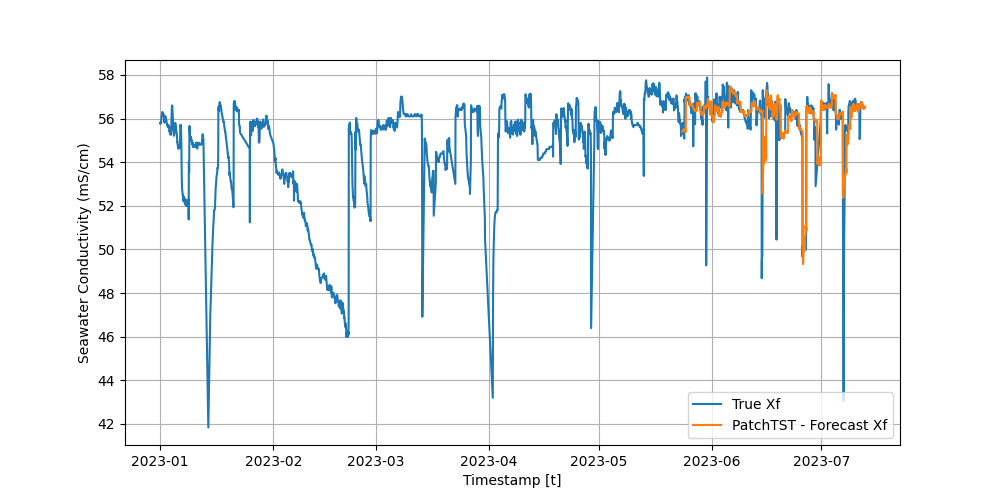

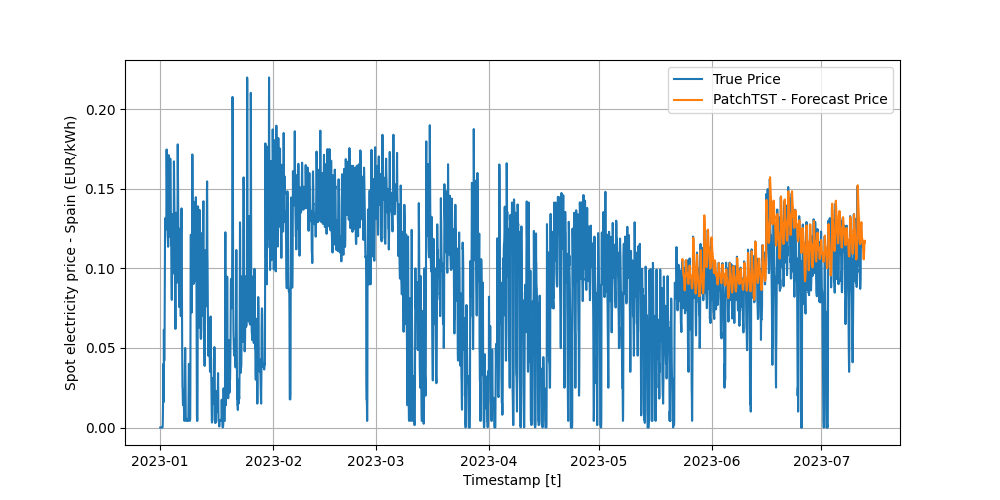

In [18]:
cv_df = Y_hat_df
unique_ids = Y_val.unique_id.unique()
for unique_id in unique_ids:
    cv_df_ = cv_df[cv_df['unique_id'] == unique_id]
    Y_val_ = Y_val[(Y_val['unique_id'] == unique_id)]

    plt.figure(figsize=(10, 5))
    plt.plot(Y_val_['ds'], Y_val_['y'], label=f'True {unique_id}')
    # plt.plot(cv_df_['ds'], cv_df_['Informer'], label=f'Informer - Forecast {unique_id}')
    # plt.plot(cv_df_['ds'], cv_df_['Autoformer'], label=f'Autoformer - Forecast {unique_id}')
    plt.plot(cv_df_['ds'], cv_df_['PatchTST'], label=f'PatchTST - Forecast {unique_id}')
    
    plt.xlabel('Timestamp [t]')
    plt.ylabel(var_name_dic[unique_id])
    plt.grid()
    plt.legend()
    plt.show()


### Evaluate results

In [29]:
for unique_id in unique_ids:
    df_ = Y_hat_df[Y_hat_df['unique_id'] == unique_id]

    for model in models:
        model = str(model)
        mae_ = mae(df_['y'], df_[model])
        mape_ = mape(df_['y'], df_[model])
    
    
        print(f'MAE -- {model} {unique_id}: {mae_:.3f}')
        print(f'MAPE -- {model} {unique_id}: {mape_:.3f}')
        print("=============================")

    print("==================================================")
    

MAE -- Informer Tsea: 7.259
MAPE -- Informer Tsea: 0.227
MAE -- Autoformer Tsea: 1.106
MAPE -- Autoformer Tsea: 0.035
MAE -- PatchTST Tsea: 0.613
MAPE -- PatchTST Tsea: 0.019
MAE -- Informer Xf: 31.733
MAPE -- Informer Xf: 0.565
MAE -- Autoformer Xf: 0.979
MAPE -- Autoformer Xf: 0.018
MAE -- PatchTST Xf: 0.518
MAPE -- PatchTST Xf: 0.010
MAE -- Informer Price: 0.290
MAPE -- Informer Price: 13.787
MAE -- Autoformer Price: 0.029
MAPE -- Autoformer Price: 9.137
MAE -- PatchTST Price: 0.020
MAPE -- PatchTST Price: 10.726
